In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from notnews import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Bashar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Bashar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
FILE_PATH = '../dataverse_files/'
PROCESSED_PATH = FILE_PATH + 'processed/'
PREDICT_NEWS = False

In [3]:
def split_text(s, n):
    pieces = str(s).split()
    return (' '.join(pieces[i:i+n]) for i in range(0, len(pieces), n))

In [4]:
def split_df(df, column, num=500):
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        w_generator = split_text(presplit, num)
        for word in w_generator:
            indexes.append(i)
            new_values.append(word)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

# Predicting Soft News probability
If PREDICT_NEWS = True then will run, this is very time consuming and should be run once
After which, the files generated should be saved to disk and preserved for future analysis
  as run time could take days depending on the number of records to analyze

In [5]:
if (PREDICT_NEWS):
    for file in os.listdir('../dataverse_files/'):
        if file.endswith(".csv"):
            print (file)
            dd = pd.read_csv( FILE_PATH + str(file), encoding = 'ISO-8859-1')
            print (f'Processing: {FILE_PATH + str(file)} ....')
            split_dd = split_df(dd, 'text')
            print (f'Finished splitting {FILE_PATH + str(file)} into chunks')
            soft_news_df = pred_soft_news_us(split_dd, col='text')
            print (f'Saving results for {FILE_PATH + str(file)}\n\n')
            soft_news_df.to_csv('{}soft_news_{}'.format(PROCESSED_PATH, file))
            os.rename(FILE_PATH+file, PROCESSED_PATH+file)

# Processing files

In [6]:
full_df = pd.DataFrame()

## Processing CNN Files

In [7]:
# Processing CNN files
processed_files = glob.glob(PROCESSED_PATH + 'soft_news_cnn*.csv')


for file in processed_files:
    news_df = pd.read_csv(file, encoding = 'ISO-8859-1')

    news_df['channel.name'] = 'CNN'
    # delete any outliers
    news_df = news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0)
    news_df = news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0)    

    # generate date field in format YYYY-MM-DD
    news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')
    
    # cleaning up the dataframe and appending to the full dataframe
    news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]
    full_df = pd.concat([full_df, news_df], axis=0)
    

In [8]:
del news_df
full_df.shape

(2748284, 4)

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748284 entries, 0 to 1114473
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   channel.name       object        
 1   program.name       object        
 2   prob_soft_news_us  float64       
 3   full_date          datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 104.8+ MB


## Processing NBC/MSNBC files
these files have different formats so we'll need to process individually

### MSNBC 2003-2014 data

In [10]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc--2003--2014.csv')
news_df.rename(columns={'Source':'channel.name', 'Show':'program.name'},inplace=True)
news_df['full_date'] = pd.to_datetime(news_df.Date)

# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]

### MSNBC 2010-2021 data

In [11]:
news2_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc-2010--2021.csv')
news2_df.drop('program.name', axis=1, inplace=True)
news2_df.rename(columns={'Source':'channel.name', 'show_name':'program.name'},inplace=True)
news2_df['full_date'] = pd.to_datetime(news2_df.air_date)

# keeping only the required columns in the dataframe
news2_df = news2_df[news2_df.columns[news2_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]


/Users/Bashar/opt/anaconda3/envs/nonconform/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
print (f'Size of 2003-2014 df: {news_df.shape}')
print (f'Size of 2010-2021 df: {news2_df.shape}')

Size of 2003-2014 df: (252433, 4)
Size of 2010-2021 df: (163122, 4)


Merging the 2 dataframes to see if there is any redundant records

In [13]:
news_df.merge(news2_df, how='outer', on=['channel.name','program.name','full_date', 'prob_soft_news_us'])

,channel.name,program.name,prob_soft_news_us,full_date
0,MSNBC,HARDBALL,0.117768,2002-09-24
1,MSNBC,HARDBALL,0.048173,2002-09-24
2,MSNBC,HARDBALL,0.485402,2002-09-24
3,MSNBC,HARDBALL,0.086091,2002-09-24
4,MSNBC,HARDBALL,0.265826,2002-09-24
...,...,...,...,...
415550,MSNBC,The 11th Hour,0.058611,2022-02-02
415551,MSNBC,The 11th Hour,0.104432,2022-02-02
415552,MSNBC,The 11th Hour,0.080886,2022-02-02
415553,MSNBC,The 11th Hour,0.301714,2022-02-02


In [14]:
full_df = pd.concat([full_df, news_df], axis=0)

In [15]:
full_df.shape

(3000717, 4)

In [16]:
del news2_df

### Processing NBC News data

In [17]:
news_df = pd.read_csv('../dataverse_files/processed/soft_news_msnbc.csv', encoding = 'ISO-8859-1')
news_df['channel.name'] = 'NBC News'

In [18]:
news_df.drop(news_df[news_df['date'].isnull()].index, inplace=True)

In [19]:
news_df = news_df.drop(news_df[news_df['year'] > 2100.0].index , axis=0)
news_df = news_df.drop(news_df[news_df['year'] < 1900.0].index , axis=0)    

news_df['full_date'] = pd.to_datetime((news_df.year*10000+news_df.month*100+news_df.date),format='%Y%m%d')

In [20]:
# keeping only the required columns in the dataframe
news_df = news_df[news_df.columns[news_df.columns.isin(['channel.name','program.name','full_date','prob_soft_news_us'])]]

full_df = pd.concat([full_df, news_df], axis=0)

In [21]:
full_df.shape

(3089450, 4)

In [22]:
del news_df

# Analysis Plots

In [23]:
soft_news_df_grp = full_df.groupby(['program.name','channel.name'])['prob_soft_news_us'].mean().reset_index()

/Users/Bashar/opt/anaconda3/envs/nonconform/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


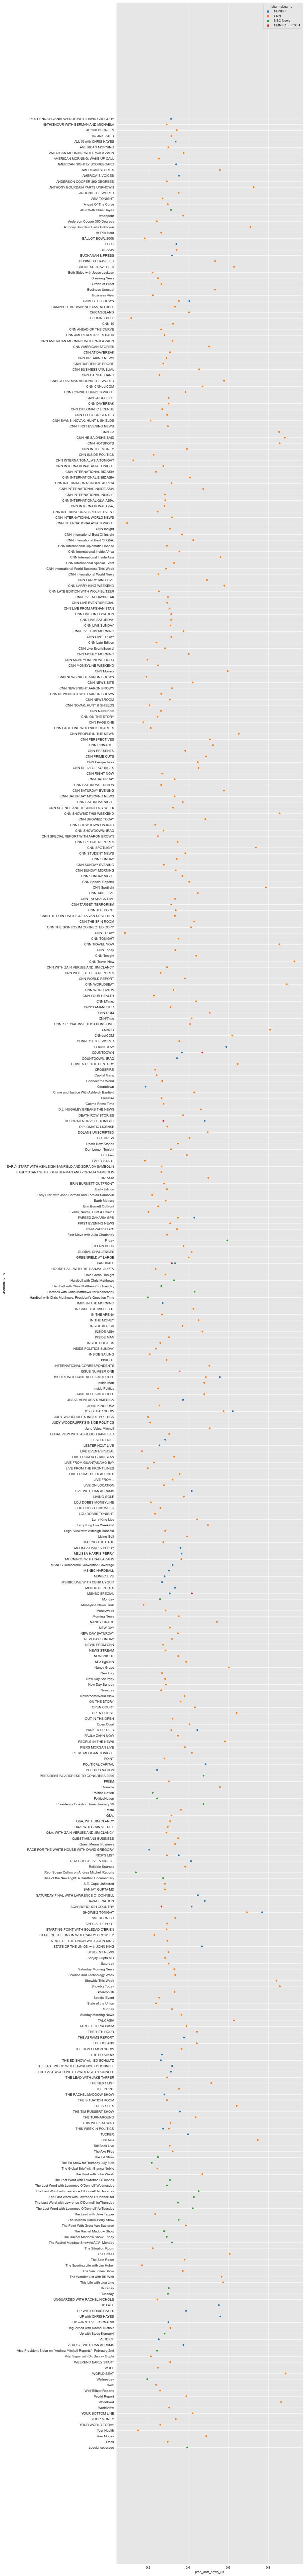

In [25]:
# Use column names of df for the different parameters x, y, color, ...

fig, ax = plt.subplots(figsize=(10,soft_news_df_grp.shape[0]/3))
sns.scatterplot(x="prob_soft_news_us", y="program.name", data=soft_news_df_grp,
                      hue="channel.name", ax=ax, size_norm=.2
                )
sns.set_style("darkgrid", {"axes.facecolor": ".9"})